In [97]:
import pandas as pd
import numpy as np
from income_parser import IncomeParser
from declarator_generator import declarator_generator
import requests
API = 'https://declarator.org/api/v1/search/sections'

In [121]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [87]:
offices = pd.read_csv('offices.csv', sep=';').set_index('id')

In [88]:
tree = {}
parent = {}

In [89]:
for row in offices['parent_id'].items():
    if not np.isnan(row[1]):
        a, b = int(row[0]), int(row[1])
        if b not in tree:
            tree[b] = []
        tree[b].append(a)
        parent[a] = b
        

In [180]:
def root_office(office, up = 2):
    for i in range(up):
        if office in parent:
            office = parent[office]
        else:
            return office
    return office
def single_office_data(office):
    for res in declarator_generator(requests.get(API, {'office': office})):
        income = 0
        for inc in res['incomes']:
            income += inc['size']
        square = 0
        for est in res['real_estates']:
            if est['square'] is not None:
                square += est['square']
        yield {'id' : res['main']['person']['id'], 'income': income, 'square': square}
def recursive_office_data(office):
    for res in single_office_data(office):
        yield res
    for child in tree.get(office, []):
        for res in recursive_office_data(child):
            yield res
def outlier_k(incomes):
    data = pd.DataFrame(incomes).set_index('id')
    model = IsolationForest(n_estimators=200)
    return (1 - sum(list(map(lambda x: max(x, 0),model.fit_predict(data)))) / len(data)) ** 3
def office_id_to_outlier_k(office):
    return outlier_k(list(recursive_office_data(root_office(office))))

In [181]:
outlier_k(list(recursive_office_data(4327)))

Retrieving another page...


/home/xallt/.local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/xallt/.local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


0.0011070564598794535

In [135]:
data = list(recursive_office_data(4327))
data = pd.DataFrame(data).set_index('id')

Retrieving another page...


In [167]:
model = IsolationForest(max_features=1.0)
model.fit(data)

/home/xallt/.local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/xallt/.local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


IsolationForest(behaviour='old', bootstrap=False, contamination='legacy',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [168]:
score = model.score_samples(data)
score - np.mean(score)

array([ 0.06591126,  0.04621343, -0.0705381 ,  0.04343289,  0.05849394,
        0.05571637,  0.06331052, -0.33904038, -0.14304633, -0.02082732,
       -0.06545507,  0.02851094, -0.17388995, -0.03286956,  0.05911688,
        0.00969374,  0.03536948,  0.05718835,  0.04888143, -0.34777768,
       -0.07107797, -0.0952977 ,  0.06916707, -0.29259544,  0.01151065,
       -0.29023923,  0.07145108,  0.05648347,  0.05551878,  0.05269319,
       -0.02472848,  0.03815823, -0.02901602,  0.04300679,  0.05947079,
        0.04013149, -0.02802203, -0.07161741,  0.05572588,  0.0574561 ,
        0.04620474,  0.05470529,  0.05555937,  0.00600316,  0.03693665,
        0.04520614,  0.0369687 , -0.09024297,  0.03083109, -0.00304911,
       -0.10114966, -0.02152877,  0.00265417,  0.03417893, -0.13602862,
        0.04892493,  0.04985976,  0.01692514,  0.01887091, -0.14709996,
        0.0562523 ,  0.03221447,  0.06751263,  0.0573232 ,  0.04506865,
       -0.01293277,  0.03245062,  0.0704143 ,  0.0345998 ,  0.03

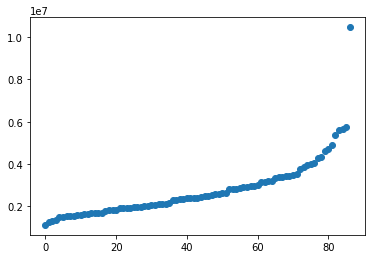

In [92]:
import matplotlib.pyplot as plt
%matplotlib inline
inc = list(map(lambda x : x['income'], incomes))
#plt.yscale('log')
plt.scatter(range(len(incomes)), sorted(inc))